# Automating a medical image segmentation problem

In this lab you will be automating a real medical imaging problem.

You will be building a system for prostate gland segmentation on MR images. The dataset is provided [here](https://github.com/s-sd/EMS741/tree/main/tutorials/images).

With this data, there is a known problem, segmentation NNs do not do very well when the prostate gland is not present in the image i.e., they create false positives.

As such, you will need to build a system which:
1) classifies an image as prostate gland present vs absent
2) segment gland using a segmentation NN only if gland present

This will require two neural networks corresponding to the two tasks above. Your task in this lab is to build, train and evaluate (quantitatively and qualitatively) these two NNs using the given dataset.

Then you should write a function, which takes in an image and returns the segmentation if the gland is present, or returns a null value if the gland is absent.

Optional: Compare this two-step approach against a segmentation network which does not have the first, presence classification, step.

### Download the dataset

In [1]:
!wget -O images_lab_data.zip https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip

--2026-02-20 17:30:28--  https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip [following]
--2026-02-20 17:30:28--  https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23924619 (23M) [application/zip]
Saving to: ‘images_lab_data.zip’

images_lab_data.zip 100%[===================>]  22.82M   124MB/s    in 0.2s    

2026-02-20 17:30:28 (124 MB/s) - ‘images_lab

In [2]:
import zipfile
import os

path_to_zip = r'images_lab_data.zip'
path_to_extract_to = r'./'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

In [3]:
!ls

# we are interested in 'images' and 'masks'

images	images_lab_data.zip  masks  sample_data


### Data checks

Before you proceed with building your segmentation system, load in a single image and corresponding mask to verify that they are paired correctly. And to check their shapes etc. Hint: use the matplotlib imread function.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

images_file_names = np.array(sorted(os.listdir('images')))
masks_file_names = np.array(sorted(os.listdir('masks')))

#shuffle the image and masks using the same order
shuffle_indexes = np.array(np.random.permutation(len(images_file_names)), dtype=np.int32)

images_file_names_shuffled = images_file_names[shuffle_indexes]
masks_file_names_shuffled = masks_file_names[shuffle_indexes]

print(images_file_names_shuffled[0], masks_file_names_shuffled[0])

sample_82_slice_015.png sample_82_slice_015.png


images/sample_350_slice_007.png masks/sample_350_slice_007.png


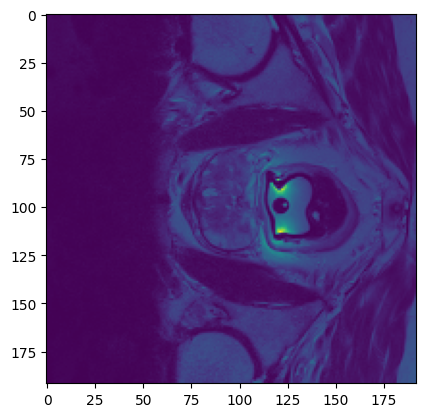

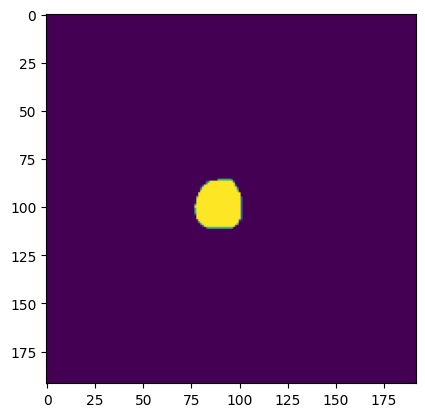

In [5]:
sample_number_to_plot = 10

image_path = os.path.join(r'images', images_file_names_shuffled[sample_number_to_plot])
mask_path = os.path.join(r'masks', masks_file_names_shuffled[sample_number_to_plot])

print(image_path, mask_path)

image = plt.imread(image_path)
mask = plt.imread(mask_path)

plt.imshow(image)

plt.figure()
plt.imshow(mask)

In [6]:
print(np.amin(image), np.amax(image))
print(np.amin(mask), np.amax(mask))
print(image.shape, mask.shape)

# this is what we can use to quickly get a classification label
# if the sum of all pixels in the mask is >1 then prostate exists
# if the sum is 0 then prostate does not exist
print(int(np.sum(mask, axis=None)>1))

0.0 1.0
0.0 1.0
(192, 192) (192, 192)
1


### Your segmentation approach

Now it's time to build your segmentation system

In [31]:
# python generator for classification

def my_classification_data_generator(batch_size, x_shape, y_shape, file_names, images_file_path, masks_file_path):

  while True:

    batch_x = np.zeros((batch_size, *x_shape))
    batch_y = np.zeros((batch_size, *y_shape))

    for i in range(batch_size):

      index = np.random.randint(len(file_names))

      image = plt.imread(os.path.join(images_file_path, file_names[index]))

      mask = plt.imread(os.path.join(masks_file_path, file_names[index]))
      classification = int(np.sum(mask, axis=None)>1)

      batch_x[i] = image
      batch_y[i] = classification

    batch_x = np.expand_dims(batch_x, axis=1) # as torch follows c, h, w

    yield batch_x, batch_y


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

# In PyTorch we use (C, H, W)
# where C=1

class MinimalAlexNet(nn.Module):
    def __init__(self, input_shape_chw):
        super().__init__()
        c, h, w = input_shape_chw

        self.features = nn.Sequential(
            nn.Conv2d(c, 64, kernel_size=11, stride=4, padding=5), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # compute flatten size dynamically from input shape
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            n_flat = self.features(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, 512), nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

torch_image_shape = (1, image.shape[0], image.shape[1])
classification_model = MinimalAlexNet(torch_image_shape)

optimizer = optim.Adam(classification_model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # matches binary_crossentropy with sigmoid output

In [32]:
# split file names into relevant sets

train_val_test_ratio = [0.6, 0.2, 0.2]

num_files = len(images_file_names_shuffled)

train_val_test_ratio = [0.6, 0.2, 0.2]

train_index_start = 0
train_index_end = int(train_val_test_ratio[0] * num_files)

val_index_start = train_index_end
val_index_end = val_index_start + int(train_val_test_ratio[1] * num_files)

test_index_start = val_index_end
test_index_end = test_index_start + int(train_val_test_ratio[2] * num_files)

train_file_names = images_file_names_shuffled[train_index_start:train_index_end]
val_file_names = images_file_names_shuffled[val_index_start:val_index_end]
test_file_names = images_file_names_shuffled[test_index_start:test_index_end]


In [34]:
# train model

batch_size = 64
x_shape = image.shape
y_shape = [1]
images_file_path = r'images'
masks_file_path = r'masks'

train_gen = my_classification_data_generator(batch_size, x_shape, y_shape, train_file_names, images_file_path, masks_file_path)

val_gen = my_classification_data_generator(batch_size, x_shape, y_shape, val_file_names, images_file_path, masks_file_path)



steps_per_epoch = 128
epochs = 4
validation_steps = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model = classification_model.to(device)


for epoch in range(epochs):
    classification_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for step in range(steps_per_epoch):
        x, y = next(train_gen)
        x = torch.as_tensor(x, dtype=torch.float32, device=device)
        y = torch.as_tensor(y, dtype=torch.float32, device=device)

        preds = classification_model(x)
        y = y.view_as(preds)

        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += ((preds >= 0.5).float() == y).sum().item()
        train_total += y.numel()

    classification_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for _ in range(validation_steps):
            x, y = next(val_gen)
            x = torch.as_tensor(x, dtype=torch.float32, device=device)
            y = torch.as_tensor(y, dtype=torch.float32, device=device)

            preds = classification_model(x)
            y = y.view_as(preds)

            loss = criterion(preds, y)

            val_loss += loss.item()
            val_correct += ((preds >= 0.5).float() == y).sum().item()
            val_total += y.numel()

    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss/steps_per_epoch:.4f} - accuracy: {train_correct/train_total:.4f} - val_loss: {val_loss/validation_steps:.4f} - val_accuracy: {val_correct/val_total:.4f}")

Epoch 1/4 - loss: 0.3632 - accuracy: 0.8469 - val_loss: 0.2371 - val_accuracy: 0.8691
Epoch 2/4 - loss: 0.0746 - accuracy: 0.9722 - val_loss: 0.4641 - val_accuracy: 0.9180
Epoch 3/4 - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.3246 - val_accuracy: 0.9492
Epoch 4/4 - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.2038 - val_accuracy: 0.9551


In [35]:
test_gen = my_classification_data_generator(batch_size, x_shape, y_shape, test_file_names, images_file_path, masks_file_path)

classification_model.eval()
criterion = nn.BCELoss()

steps = 64
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for step in range(steps):
        x, y = next(test_gen)

        x = torch.as_tensor(x, dtype=torch.float32, device=device)
        y = torch.as_tensor(y, dtype=torch.float32, device=device)

        preds = classification_model(x)
        y = y.view_as(preds)

        loss = criterion(preds, y)

        test_loss += loss.item()
        test_correct += ((preds >= 0.5).float() == y).sum().item()
        test_total += y.numel()

avg_loss = test_loss / steps
avg_acc = test_correct / test_total

print(f"loss: {avg_loss:.4f} - accuracy: {avg_acc:.4f}")

loss: 1.5944 - accuracy: 0.9270


### Now let's do a segmentation model

In [36]:
# data generator for segmentation

def my_segmentation_data_generator(batch_size, x_shape, y_shape, file_names, images_file_path, masks_file_path):

  while True:

    batch_x = np.zeros((batch_size, *x_shape))
    batch_y = np.zeros((batch_size, *y_shape))

    for i in range(batch_size):

      index = np.random.randint(len(file_names))

      image = plt.imread(os.path.join(images_file_path, file_names[index]))
      mask = plt.imread(os.path.join(masks_file_path, file_names[index]))

      batch_x[i] = image
      batch_y[i] = mask

    batch_x = np.expand_dims(batch_x, axis=1) # because torch uses c, h, w
    batch_y = np.expand_dims(batch_y, axis=1)

    yield batch_x, batch_y

In [37]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.c1a = nn.Conv2d(in_channels, 32, 3, padding=1); self.c1b = nn.Conv2d(32, 32, 3, padding=1); self.p1 = nn.MaxPool2d(2)
        self.c2a = nn.Conv2d(32, 64, 3, padding=1); self.c2b = nn.Conv2d(64, 64, 3, padding=1); self.p2 = nn.MaxPool2d(2)
        self.c3a = nn.Conv2d(64, 128, 3, padding=1); self.c3b = nn.Conv2d(128, 128, 3, padding=1); self.p3 = nn.MaxPool2d(2)

        self.c4a = nn.Conv2d(128, 256, 3, padding=1); self.c4b = nn.Conv2d(256, 256, 3, padding=1)

        self.up1 = nn.Upsample(scale_factor=2, mode="nearest"); self.u1a = nn.Conv2d(256+128, 128, 3, padding=1); self.u1b = nn.Conv2d(128, 128, 3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode="nearest"); self.u2a = nn.Conv2d(128+64, 64, 3, padding=1); self.u2b = nn.Conv2d(64, 64, 3, padding=1)
        self.up3 = nn.Upsample(scale_factor=2, mode="nearest"); self.u3a = nn.Conv2d(64+32, 32, 3, padding=1); self.u3b = nn.Conv2d(32, 32, 3, padding=1)

        self.out = nn.Conv2d(32, out_channels, 1)
        self.act = nn.ReLU(inplace=True)
        self.final = nn.Sigmoid() if out_channels == 1 else nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.act(self.c1a(x)); x1 = self.act(self.c1b(x1)); p1 = self.p1(x1)
        x2 = self.act(self.c2a(p1)); x2 = self.act(self.c2b(x2)); p2 = self.p2(x2)
        x3 = self.act(self.c3a(p2)); x3 = self.act(self.c3b(x3)); p3 = self.p3(x3)

        b = self.act(self.c4a(p3)); b = self.act(self.c4b(b))

        y = self.up1(b); y = torch.cat([y, x3], dim=1); y = self.act(self.u1a(y)); y = self.act(self.u1b(y))
        y = self.up2(y); y = torch.cat([y, x2], dim=1); y = self.act(self.u2a(y)); y = self.act(self.u2b(y))
        y = self.up3(y); y = torch.cat([y, x1], dim=1); y = self.act(self.u3a(y)); y = self.act(self.u3b(y))

        return self.final(self.out(y))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segmentation_model = SimpleUNet(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(segmentation_model.parameters())
criterion = nn.BCELoss()

In [45]:
# train model

batch_size = 32
x_shape = image.shape
y_shape = mask.shape
images_file_path = r'images'
masks_file_path = r'masks'

train_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, train_file_names, images_file_path, masks_file_path)

val_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, val_file_names, images_file_path, masks_file_path)

# this is just a demonstration, you need to train your network for more steps / epochs
steps_per_epoch = 32
epochs = 8
validation_steps = 4

history = {"loss": [], "val_loss": []}

for epoch in range(epochs):
    segmentation_model.train()
    train_loss = 0.0

    for step in range(steps_per_epoch):
        x, y = next(train_gen)  # yields (N,H,W,1) for both

        x = torch.as_tensor(x, dtype=torch.float32, device=device)
        y = torch.as_tensor(y, dtype=torch.float32, device=device)

        preds = segmentation_model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    segmentation_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(validation_steps):
            x, y = next(val_gen)

            x = torch.as_tensor(x, dtype=torch.float32, device=device)
            y = torch.as_tensor(y, dtype=torch.float32, device=device)

            preds = segmentation_model(x)
            val_loss += criterion(preds, y).item()

    train_loss /= steps_per_epoch
    val_loss /= validation_steps

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

Epoch 1/8 - loss: 0.0820 - val_loss: 0.0802
Epoch 2/8 - loss: 0.0674 - val_loss: 0.0687
Epoch 3/8 - loss: 0.0485 - val_loss: 0.0436
Epoch 4/8 - loss: 0.0383 - val_loss: 0.0352
Epoch 5/8 - loss: 0.0331 - val_loss: 0.0352
Epoch 6/8 - loss: 0.0300 - val_loss: 0.0269
Epoch 7/8 - loss: 0.0237 - val_loss: 0.0266
Epoch 8/8 - loss: 0.0230 - val_loss: 0.0254


Text(0.5, 1.0, 'predicted')

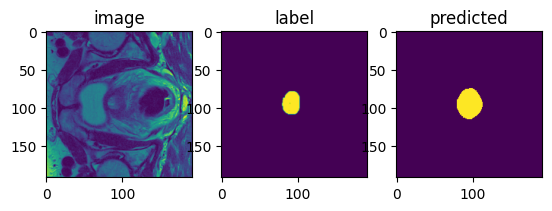

In [47]:
test_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, test_file_names, images_file_path, masks_file_path)


test_batch_x, test_batch_y = next(test_gen)

def my_prostate_segmentation_function(image):
    classification_model.eval()
    segmentation_model.eval()

    with torch.no_grad():
        x = torch.as_tensor(image, dtype=torch.float32, device=device)

        classification = classification_model(x)
        classification = torch.round(classification).to(torch.int32)

        if classification.item() == 0:
            return None

        segmentation = segmentation_model(x)
        segmentation = (segmentation > 0.5).to(torch.uint8)

        return segmentation.cpu().numpy()

index = 0

segmentation = my_prostate_segmentation_function(test_batch_x[index:index+1])

if segmentation is None:
    segmentation = np.zeros(y_shape, dtype=np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(np.squeeze(test_batch_x[index]))
ax1.set_title('image')

ax2.imshow(np.squeeze(test_batch_y[index]))
ax2.set_title('label')

ax3.imshow(np.squeeze(segmentation))
ax3.set_title('predicted')